In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

import kMeans

###########################################################################################################################################################################
#########################################################           IMPORTACIONES       ##################################################################################
###########################################################################################################################################################################

train  = pd.read_csv("suicidal_data.csv",sep=",", encoding='cp1252')




###########################################################################################################################################################################
#########################################################           PREPROCESO       ##################################################################################
###########################################################################################################################################################################


def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt

print('Dataset size:',train.shape)
print('columns are:',train.columns)

length_train = train['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.legend()
plt.show()

train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*")

train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()


for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

train['tidy_tweet'] = tokenized_tweet

import nltk.corpus

stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['fuck', 'shit'])


def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

# combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: remove_stopwords(x)) # stemming
# combi.head()

train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))

#visualize all the words our data using the wordcloud plot
all_words = ' '.join([text for text in train['tidy_tweet']])


###########################################################################################################################################################################
#########################################################           MUESTRA DEL CONJUNTO       ##################################################################################
###########################################################################################################################################################################
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#Non-suicide
print("non-suicide:")
normal_words =' '.join([text for text in train['tidy_tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#Suicide
print("suicide:")
negative_words = ' '.join([text for text in train['tidy_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()



###########################################################################################################################################################################
#########################################################           VECTORIZACION       ##################################################################################
###########################################################################################################################################################################
#Bag-of-words
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['tidy_tweet'])
bow.shape
# bow[:5]


#Tf-IDF
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tidy_tweet'])




#Word embbeding
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tidy_tweet']), epochs=20)

print(model_w2v.wv.most_similar(positive="die"))

print(model_w2v.wv.most_similar(positive="suicid"))

model_w2v.wv.get_vector('suicid')



def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary

            continue
    if count != 0:
        vec /= count
    return vec


wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

labeled_tweets[:6]


model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)
print("Conseguido")
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(train['tidy_tweet']), epochs=15)

docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(train)):
    docvec_arrays[i, :] = model_d2v.dv[i].reshape((1, 200))

docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape


#print("hecho lo dificil")



In [ ]:

###########################################################################################################################################################################
#########################################################           CLUSTERING       ##################################################################################
###########################################################################################################################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

###################################### Bag-of-Words Features ##########################
train_bow = bow

# train_bow = bow[:7365,0:1]
# test_bow = bow[7365:,1:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow.toarray(), train['label'],
                                                          random_state=42,
                                                          test_size=0.2)
train_bow.shape


kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(xtrain_bow)

cluster_labels = kmeans.predict(xvalid_bow)

print("----- METRICAS PARA BOW CON KMEANS -------")
print(f"Accuracy: {accuracy_score(yvalid, cluster_labels)}")
print(f"Precision: {precision_score(yvalid, cluster_labels, average='macro')}")
print(f"Recall: {recall_score(yvalid, cluster_labels, average='macro')}")
print(f"F1-Score:{f1_score(yvalid, cluster_labels, average='micro')}")
print(f"Confusion Matrix: \n {confusion_matrix(yvalid, cluster_labels)} \n")
print(f"Silhouette Score: {silhouette_score(xvalid_bow, cluster_labels)}")



##################################### TF-IDF Features ##########################

train_tfidf = tfidf_matrix

xtrain_tfidf = train_tfidf[ytrain.index].toarray()
xvalid_tfidf = train_tfidf[yvalid.index].toarray()

kmeans.fit(xtrain_tfidf)

cluster_labels = kmeans.predict(xvalid_tfidf)

print("----- METRICAS PARA TF-IDF CON KMEANS -------")
print(f"Accuracy: {accuracy_score(yvalid, cluster_labels)}")
print(f"Precision: {precision_score(yvalid, cluster_labels, average='macro')}")
print(f"Recall: {recall_score(yvalid, cluster_labels, average='macro')}")
print(f"F1-Score:{f1_score(yvalid, cluster_labels, average='micro')}")
print(f"Confusion Matrix: \n {confusion_matrix(yvalid, cluster_labels)} \n \n")

############################### Word-Embedding Features ########################
# Word2vec Features
train_w2v = wordvec_df

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

xtrain_w2v.shape

kmeans.fit(xtrain_w2v)

cluster_labels = kmeans.predict(xvalid_w2v)

print("----- METRICAS PARA WORD EMBEDDING CON KMEANS -------")
print(f"Accuracy: {accuracy_score(yvalid, cluster_labels)}")
print(f"Precision: {precision_score(yvalid, cluster_labels, average='macro')}")
print(f"Recall: {recall_score(yvalid, cluster_labels, average='macro')}")
print(f"F1-Score:{f1_score(yvalid, cluster_labels, average='micro')}")
print(f"Confusion Matrix: \n {confusion_matrix(yvalid, cluster_labels)} \n \n")

Silhouette Scores:
BoW: 0.65
TF-IDF: 0.01
Word2Vec: 0.16

Inertia:
BoW: 355123.86
TF-IDF: 7052.05
Word2Vec: 14915.96


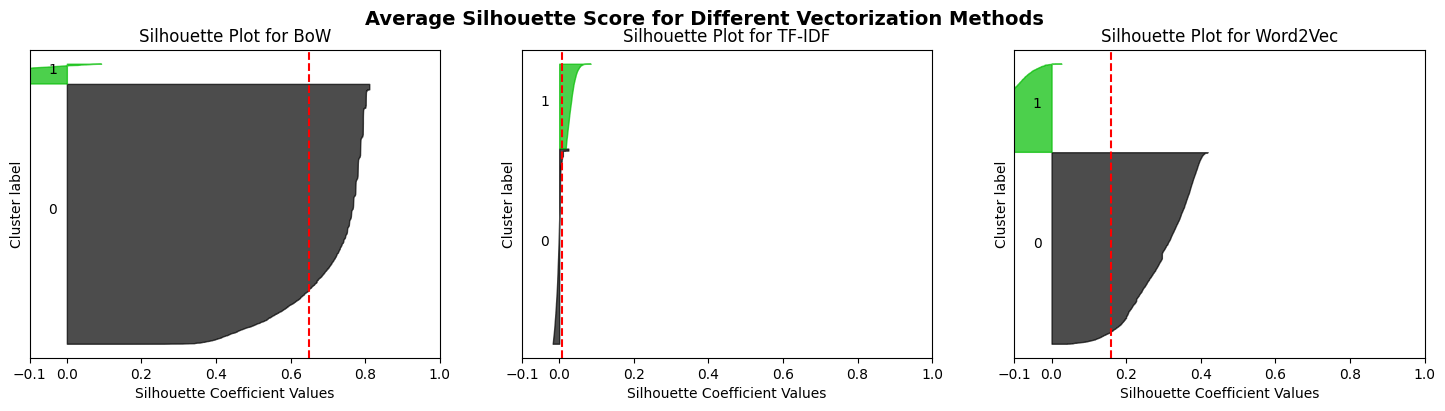

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

# Realiza la división de tus datos de BoW
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow.toarray(), train['label'],
                                                          random_state=42,
                                                          test_size=0.2)

# Realiza la división de tus datos de TF-IDF
train_tfidf = tfidf_matrix
xtrain_tfidf = train_tfidf[ytrain.index].toarray()
xvalid_tfidf = train_tfidf[yvalid.index].toarray()

# Realiza la división de tus datos de Word2Vec
train_w2v = wordvec_df
xtrain_w2v = train_w2v.iloc[ytrain.index, :]
xvalid_w2v = train_w2v.iloc[yvalid.index, :]

# Configuración de número de clusters
n_clusters = 2

# Diccionario para almacenar los datos y etiquetas de cada tipo de vectorización
data = {
    "BoW": (xtrain_bow, xvalid_bow),
    "TF-IDF": (xtrain_tfidf, xvalid_tfidf),
    "Word2Vec": (xtrain_w2v, xvalid_w2v)
}

# Variables para almacenar los resultados
silhouette_score_bow, silhouette_score_tfidf, silhouette_score_word2vec = None, None, None
inertia_bow, inertia_tfidf, inertia_word2vec = None, None, None

# Configuración de subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Average Silhouette Score for Different Vectorization Methods", fontsize=14, fontweight="bold")

for i, (vectorization_name, (xtrain, xvalid)) in enumerate(data.items()):
    ax = axes[i]
    ax.set_xlim([-0.1, 1])

    # Initialize the clusterer
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = kmeans.fit_predict(xtrain)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(xtrain, cluster_labels)
    if vectorization_name == "BoW":
        silhouette_score_bow = silhouette_avg
    elif vectorization_name == "TF-IDF":
        silhouette_score_tfidf = silhouette_avg
    elif vectorization_name == "Word2Vec":
        silhouette_score_word2vec = silhouette_avg

    # Calculate silhouette values
    sample_silhouette_values = silhouette_samples(xtrain, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        color = plt.cm.nipy_spectral(float(j) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    ax.set_title(f"Silhouette Plot for {vectorization_name}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Calcular la inercia
for vectorization_name, (xtrain, _) in data.items():
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    kmeans.fit(xtrain)
    if vectorization_name == "BoW":
        inertia_bow = kmeans.inertia_
    elif vectorization_name == "TF-IDF":
        inertia_tfidf = kmeans.inertia_
    elif vectorization_name == "Word2Vec":
        inertia_word2vec = kmeans.inertia_

print("Silhouette Scores:")
print(f"BoW: {silhouette_score_bow:.2f}")
print(f"TF-IDF: {silhouette_score_tfidf:.2f}")
print(f"Word2Vec: {silhouette_score_word2vec:.2f}")

print("\nInertia:")
print(f"BoW: {inertia_bow:.2f}")
print(f"TF-IDF: {inertia_tfidf:.2f}")
print(f"Word2Vec: {inertia_word2vec:.2f}")

plt.show()